In [1]:
import pandas as pd
from datasets import load_dataset
from diff_predictor import data_process, predxgboost
from os import listdir, getcwd, chdir
from os.path import isfile, join
import numpy as np
from sklearn import preprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir, getcwd, chdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import operator
import xgboost as xgb
from xgboost.training import CVPack
from xgboost import callback
from xgboost.core import CallbackEnv
from xgboost.core import EarlyStopException
from xgboost.core import STRING_TYPES

import seaborn as sns
import shap


/Users/nelsschimek/anaconda3/envs/diff_predictor_env/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/nelsschimek/anaconda3/envs/diff_predictor_env/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-

In [2]:
url = "https://huggingface.co/datasets/nlsschim/age_feature_csvs/resolve/main/"
dataset = load_dataset("csv", data_files={
    'p14_data': url + 'p14_data.csv',
    #'p21_data': url + 'p21_data.csv',
    #'p28_data': url + 'p28_data.csv',
    'p35_data': url + 'p35_data.csv',
    #'p70_data': url + 'p70_data.csv',
   
})

Found cached dataset csv (/Users/nelsschimek/.cache/huggingface/datasets/csv/default-9a5449cf8d2cb7af/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
url = "https://huggingface.co/datasets/nlsschim/age_feature_csvs/resolve/main/"
dataset_p70 = load_dataset("csv", data_files={'p70_data': url + 'p70_data.csv',})

Found cached dataset csv (/Users/nelsschimek/.cache/huggingface/datasets/csv/default-afad649c25c316ff/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
p14_df = dataset['p14_data'].to_pandas()
#p21_df = dataset['p21_data'].to_pandas()
#p28_df = dataset['p28_data'].to_pandas()
p35_df = dataset['p35_data'].to_pandas()
p70_df = dataset_p70['p70_data'].to_pandas()

In [5]:
fstats_tot = pd.concat([p14_df, p35_df, p70_df], ignore_index=True)

In [6]:
fstats_tot.columns

Index(['Track_ID', 'alpha', 'D_fit', 'kurtosis', 'asymmetry1', 'asymmetry2',
       'asymmetry3', 'AR', 'elongation', 'boundedness', 'fractal_dim',
       'trappedness', 'efficiency', 'straightness', 'MSD_ratio', 'frames', 'X',
       'Y', 'Quality', 'Mean_Intensity', 'SN_Ratio', 'Deff1', 'Deff2',
       'angle_mean', 'angle_mag_mean', 'angle_var', 'convex_hull',
       'convex_hull_norm', 'dist_tot', 'dist_net', 'progression', 'Mean alpha',
       'Std alpha', 'Mean D_fit', 'Std D_fit', 'Mean kurtosis', 'Std kurtosis',
       'Mean asymmetry1', 'Std asymmetry1', 'Mean asymmetry2',
       'Std asymmetry2', 'Mean asymmetry3', 'Std asymmetry3', 'Mean AR',
       'Std AR', 'Mean elongation', 'Std elongation', 'Mean boundedness',
       'Std boundedness', 'Mean fractal_dim', 'Std fractal_dim',
       'Mean trappedness', 'Std trappedness', 'Mean efficiency',
       'Std efficiency', 'Mean straightness', 'Std straightness',
       'Mean MSD_ratio', 'Std MSD_ratio', 'Mean frames', 'Std frames

In [7]:
feature_list = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
    #'Deff1', # Effective diffusion coefficient at 0.33 s
    #'Deff2', # Effective diffusion coefficient at 3.3 s
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    #'Mean Deff1', 
    #'Mean Deff2',
    ]

In [8]:
ecm = fstats_tot[feature_list + ['age', 'X', 'Y', 'Track_ID']]
ecm = ecm[~ecm[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm = ecm.fillna(0) #setting any Deff2 values that are NA to 0
ecm.shape

(37503, 32)

In [9]:
best_param = {'max_depth': 5, 'eta': 0.01, 'min_child_weight': 0, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 3, 'silent': 'True', 'gamma': 0.2, 'subsample': 0.6, 'colsample_bytree': 0.5, 'eval_metric': 'mlogloss'}#, 'gpu_id': 0, 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'}

In [10]:
acc_list = []
true_label_list = []
preds_list = []
traj_count_list = []
frames_list = []
dist_tot_list = []
dist_net_list = []
#for i in range():
bal_ecm = data_process.balance_data(ecm, 'age')
sampled_df = data_process.bin_data(bal_ecm)
label_df = sampled_df['age']
features_df = sampled_df.drop(['age', 'X', 'Y', 'binx', 'biny', 'bins', 'Track_ID'], axis=1)
features = features_df.columns   

seed = 1234
np.random.seed(seed)
train_split = 0.8
test_split = 0.5

le = preprocessing.LabelEncoder()
sampled_df['encoded_target'] = le.fit_transform(sampled_df['age'])

training_bins = np.random.choice(sampled_df['bins'].unique(), int(len(sampled_df['bins'].unique())*train_split), replace=False)

X_train = sampled_df[sampled_df['bins'].isin(training_bins)]
X_test_val = sampled_df[~sampled_df['bins'].isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)
booster, acc, true_label, preds = predxgboost.train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=814)
acc_list.append(acc)
true_label_list.append(true_label)
preds_list.append(preds)
# frames_list.append(sampled_df['frames'].tolist())
# dist_tot_list.append(sampled_df['dist_tot'].tolist())
# dist_net_list.append(sampled_df['dist_net'].tolist())

Ratio before data balance (P14:P35:P70) = 6416:17119:13968
Ratio after balance (P14:P35:P70) = 6416:6416:6416
[0]	train-mlogloss:1.09032	eval-mlogloss:1.09045
[1]	train-mlogloss:1.08411	eval-mlogloss:1.08499
[2]	train-mlogloss:1.07620	eval-mlogloss:1.07754
[3]	train-mlogloss:1.06866	eval-mlogloss:1.07031
[4]	train-mlogloss:1.06170	eval-mlogloss:1.06342
[5]	train-mlogloss:1.05423	eval-mlogloss:1.05614
[6]	train-mlogloss:1.04664	eval-mlogloss:1.04888
[7]	train-mlogloss:1.03977	eval-mlogloss:1.04241
[8]	train-mlogloss:1.03255	eval-mlogloss:1.03562
[9]	train-mlogloss:1.02540	eval-mlogloss:1.02875
[10]	train-mlogloss:1.01895	eval-mlogloss:1.02276
[11]	train-mlogloss:1.01255	eval-mlogloss:1.01660
[12]	train-mlogloss:1.00468	eval-mlogloss:1.00905
[13]	train-mlogloss:0.99821	eval-mlogloss:1.00294
[14]	train-mlogloss:0.99418	eval-mlogloss:0.99919
[15]	train-mlogloss:0.98707	eval-mlogloss:0.99240
[16]	train-mlogloss:0.98007	eval-mlogloss:0.98581
[17]	train-mlogloss:0.97353	eval-mlogloss:0.97972


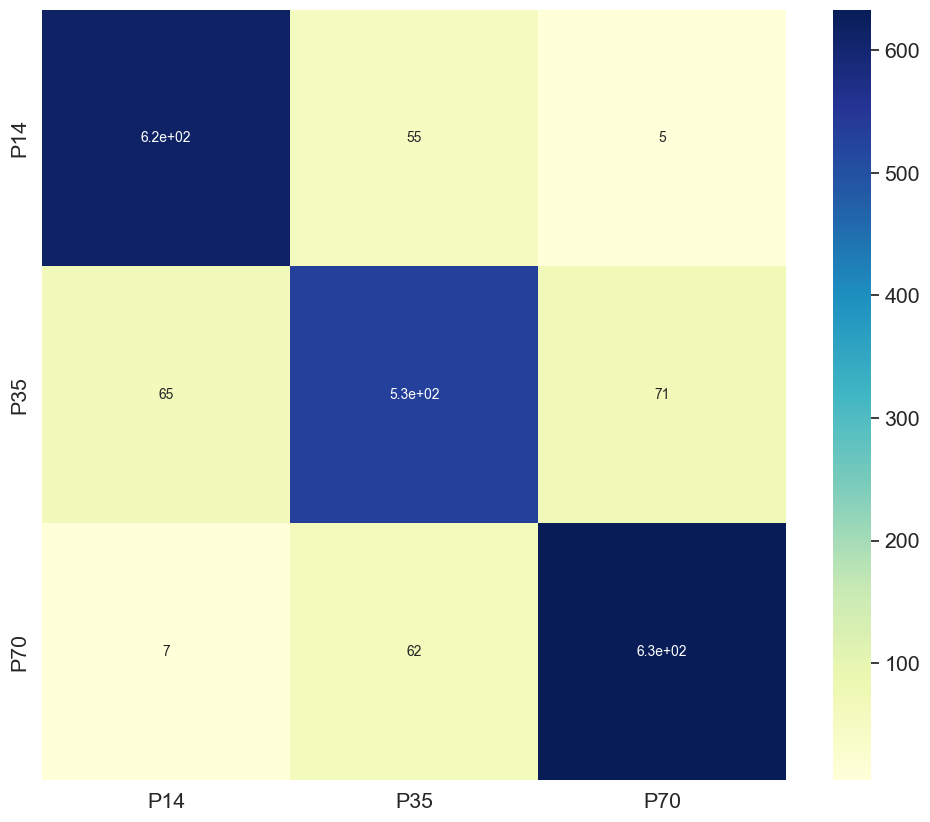

In [11]:
#make confusion matrix

class_names = le.classes_
metrics.confusion_matrix(y_test, preds)
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="YlGnBu")
# ax.set(xlabel='Predicted', ylabel='Actual')

In [12]:
booster.trees_to_dataframe

<bound method Booster.trees_to_dataframe of <xgboost.core.Booster object at 0x7f8a40948fd0>>

In [13]:
X_test[feature_list].dropna()

,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,fractal_dim,...,Mean asymmetry2,Mean asymmetry3,Mean AR,Mean elongation,Mean boundedness,Mean fractal_dim,Mean trappedness,Mean efficiency,Mean straightness,Mean MSD_ratio
33681,0.817988,6.598114,3.130803,0.932235,0.132442,0.347363,2.216493,0.548837,0.097319,1.586142,...,0.277441,0.237579,2.172670,0.436028,0.075186,1.628204,-0.204346,0.751254,0.224961,0.482750
19293,0.164143,3.287585,2.590164,0.866619,0.189140,0.264598,1.846002,0.458289,0.186920,3.498083,...,0.108929,0.410002,3.007638,0.586338,0.158144,2.923388,-0.179590,0.064972,0.055470,1.220577
3458,1.296819,5.937679,2.929438,0.406329,0.470552,0.067008,1.835734,0.455259,0.082787,1.294652,...,0.327846,0.192077,1.971273,0.442479,0.112294,1.551248,-0.193361,0.976108,0.320656,0.248738
31795,0.077798,22.624295,2.264982,0.774665,0.252477,0.196145,1.939574,0.484423,0.081405,1.511775,...,0.261521,0.260381,2.332314,0.460336,0.070866,1.681144,-0.205707,0.727692,0.187593,0.234941
31670,0.462096,36.925439,4.525243,0.997398,0.025523,0.600500,2.609629,0.616804,0.023752,1.576623,...,0.220898,0.286484,2.198061,0.470820,0.069996,1.867823,-0.205960,0.472505,0.127545,0.681458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3519,1.795859,2.225574,2.101364,0.888417,0.171959,0.287152,3.337102,0.700339,0.025080,1.233030,...,0.171071,0.326897,2.884324,0.593119,0.114906,1.407707,-0.192512,1.169219,0.357974,0.046146
36266,0.569604,6.169282,1.428674,0.987844,0.055295,0.511986,3.394416,0.705398,0.044675,1.353271,...,0.189636,0.350564,2.972642,0.600153,0.072007,1.698637,-0.205296,0.510861,0.163215,2.830611
37628,0.464002,3.090279,3.256923,0.990901,0.047802,0.532594,4.149791,0.759024,0.069650,1.534823,...,0.213041,0.293685,2.625267,0.573498,0.063156,1.735787,-0.208000,0.428980,0.128639,0.404195
5898,0.788270,5.960774,2.378846,0.718239,0.287315,0.166348,1.161336,0.138922,0.145323,1.860602,...,0.311643,0.149097,1.308053,0.225765,0.116503,1.617651,-0.191918,0.934793,0.343500,0.065102


In [15]:
explainer = shap.TreeExplainer(booster, X_test[features])
shap_values = explainer.shap_values(X_test[features])

100%|===================| 6133/6135 [12:56<00:00]        

In [ ]:
from matplotlib import plt_

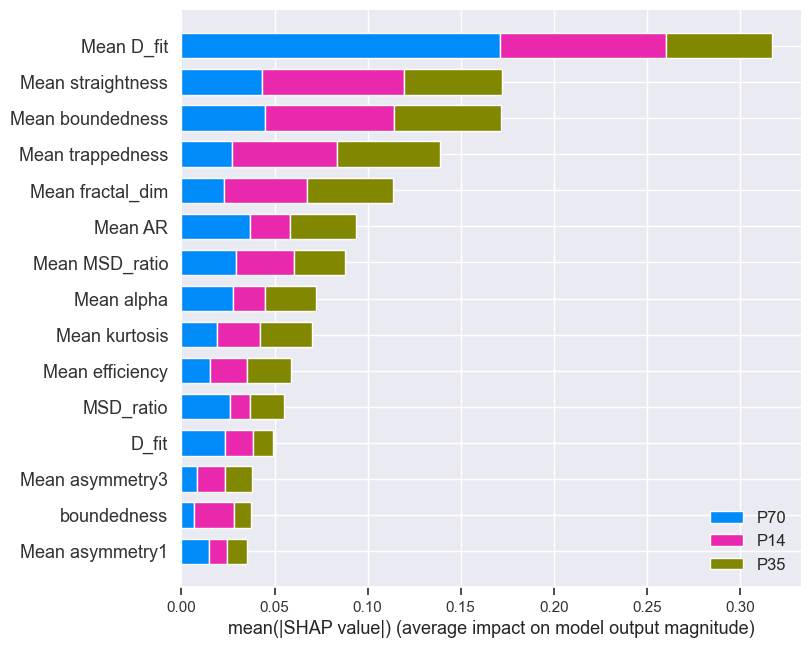

In [18]:
c_NT = '#E69F00'
c_HYase = '#56B4E9'
c_ChABC = '#009E73'

colors = [c_NT, c_HYase, c_ChABC]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
#cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), max_display=15, title='Total SHAP Values')